# Pilot Scan 2 - 6/27/18

## Scan Notes
We collected the following scans that can be found in `.../b2b/data/Raw/Subject002`

* MPRAGE - Anatomical
* 0000 - full run, REST vs finger tapping
* 0001 - short run, REST vs finger tapping
* 0002 - short run, REST vs finger tapping
* 0003 - full run, REST vs imagined tapping
* 0004 - short run, REST vs imagined tapping
* 0005 - short run, REST vs imagined tapping

All functional scans used the same parameters:

* TR: 2sec
* vol dimensions: (64,64,30)
* nTimepts: *full run*-132; *short run*-68  (+ 2 dummy timepts at start of run)

The data from the actual scan session can be found in `.../b2b/pilotScans/pilot2_real`. All offline simulations and testing of different parameters should use the data found in `.../bsb/pilotScans/pilot2_offline`

During the scan session, we:

1. ran a GLM on `0000` that modeled active>0. 
2. Extracted the peak voxel: 28 31 26
3. Build a 5mm sphere around that peak (However, we accidently used the wrong ref volume in building this mask, so it didn't work as expected. Instead, we used the full brain mask from the feat output directory for subsequent steps
4. Ran the `classifyLocalizer.py` script to train and save a classifier. Using whole brain mask, mean classification accuracy was 66%.
5. Loaded the saved classifier into the Pyneal custom analysis script along with whole brain mask. 
6. Ran 2 short runs in real-time. During runs, each volume was classified and the if the prob > 50% a trigger was sent ot the TMS server running up in Guthrie

Two Pyneal runs: `pyneal_021`, `pyneal_022`

We also collected a full run and two short runs using the motor imagery task, but these were not analyzed in real-time

In [16]:
import os
from os.path import join

import nibabel as nib
import numpy as np
import pandas as pd
from nilearn.masking import apply_mask

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
rawDir = '../../data/raw/Subject002/'
rtDir = '../../pilotScans/pilot2_offline/'
timingDir = join(rtDir, 'timingFiles')

# Finger Tapping Analysis
## Raw Activation Plots

In [18]:
def plotRaw(maskFile, runType):
    """ Plot the raw timecourse from the supplied mask
    
    Parameters
    ----------
    maskFile : string
        full path to the mask you want to extract raw signal from
    runType : string {'motor', 'imagery'}
    
    """
    # start the plot
    fig, axs = plt.subplots(3, 1, figsize=(15,10))
    plt.suptitle('{} Activation - {}'.format(runType.capitalize(), os.path.split(maskFile)[-1]), fontsize=24)
    
    # set colors
    if runType == 'motor':
        spanColor = 'dodgerBlue'
        lineColor = 'dodgerBlue'
    elif runType == 'imagery':
        spanColor = 'goldenrod'
        lineColor = 'goldenrod'
        
    # load the mask
    mask = nib.load(maskFile)
    
    # trial times
    restOnsets = np.array([(x*32)+4 for x in range(8)]) 
    activeOnsets = restOnsets + 16
    
    for i, run in enumerate(['0000', '0001', '0002']):
        
        # load and mask the func data
        funcFile = join(rtDir,('func_' + run + '.nii.gz') )
        maskedData = apply_mask(funcFile, mask)
        
        # calculate mean timeseries within mask
        meanTS = np.mean(maskedData, axis=1)
        
        # plot 
        x = np.arange(0, maskedData.shape[0]*2, 2)
        axs[i].plot(x, meanTS, '-o', color=lineColor)
        
        # spans
        theseRest = restOnsets[restOnsets < x[-1]-16]
        for r in theseRest:
            axs[i].axvspan(r, r+16, facecolor='gray', edgecolor='none', alpha=0.2)
        
        theseActive = activeOnsets[activeOnsets < x[-1]]
        for a in theseActive:
            axs[i].axvspan(a, a+16, facecolor=spanColor, edgecolor='none', alpha=0.2)
            
        axs[i].set_xlim(0,280)

### Peak Voxel from GLM

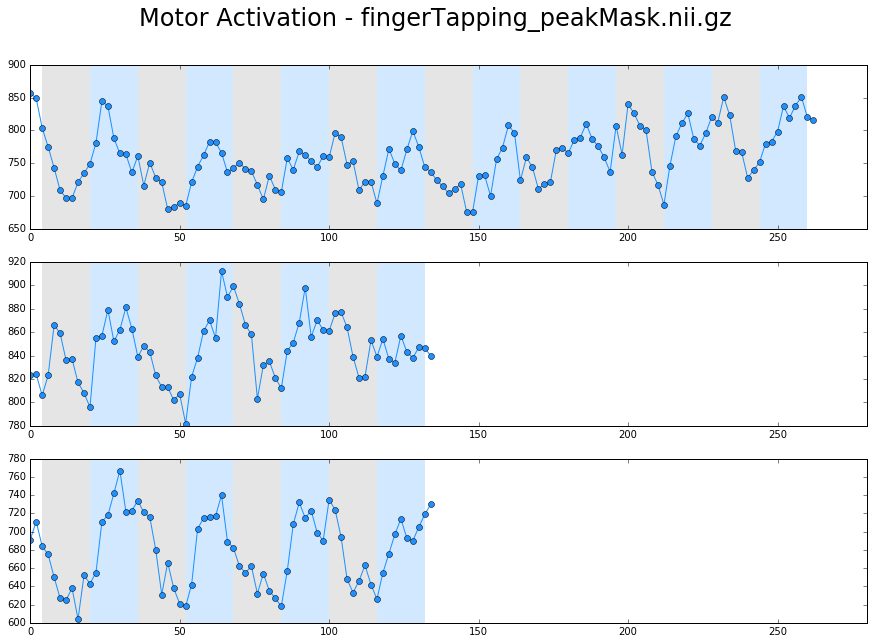

In [19]:
plotRaw(join(rtDir, 'fingerTapping_peakMask.nii.gz'), 'motor')

### 5mm Sphere around peak

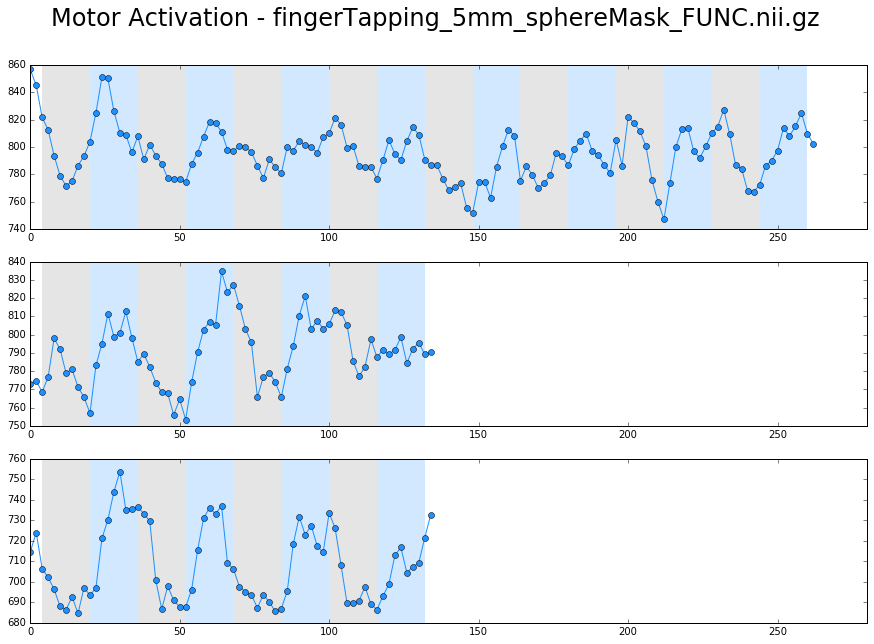

In [20]:
plotRaw(join(rtDir, 'fingerTapping_5mm_sphereMask_FUNC.nii.gz'), 'motor')

### whole brain mask

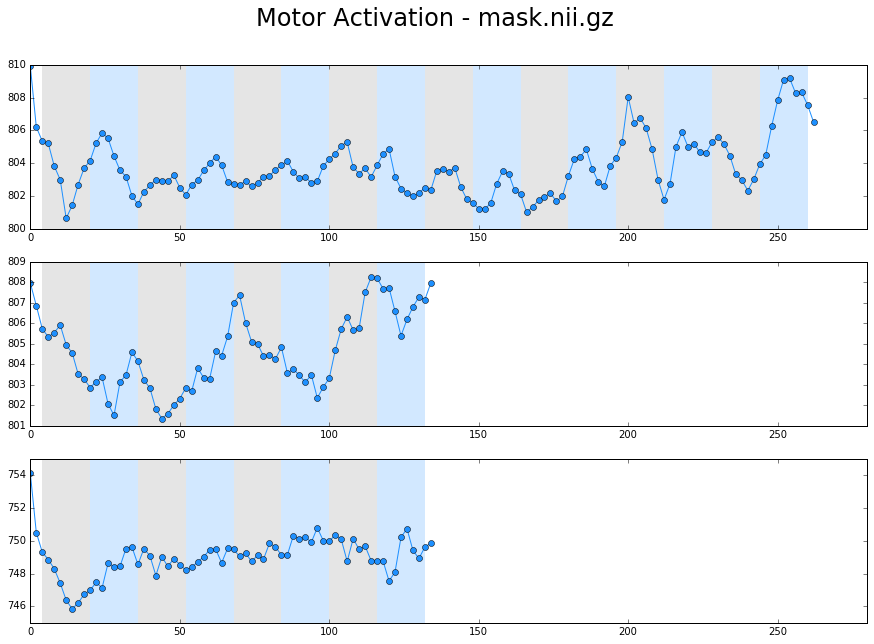

In [21]:
plotRaw(join(rtDir, 'firstLevel_fingerTapping.feat/mask.nii.gz'), 'motor')

## Train & Test Classifier Tools

In [22]:
import pickle

from nilearn.input_data import NiftiMasker
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [23]:
def buildClassifier(funcFile, maskFile, labelsFile):
    """ Train a classifier on the specified funcFile
    
    classifier will be trained using voxels found in maskFile. Timepts
    labeled according to labelsFile
    """
    # set up masker to mask and standardize input data
    masker = NiftiMasker(mask_img=maskFile, standardize=True)

    # load fMRI, apply masker
    fmri = masker.fit_transform(funcFile)
    
    # create mask to isolate conditions of interest
    labels = pd.read_table(labelsFile, header=None, squeeze=True)
    conditions_mask = labels.isin(['Rest', 'Active'])
    
    # mask fmri timepts
    fmri = fmri[conditions_mask]
    
    # mask labels
    labels = labels[conditions_mask]
    
    # build the classifier object
    clf = SVC(kernel='linear', C=100, probability=True)
    
    # see how classifier performs through cross validation
    cv = KFold(n_splits=5)
    cv_score = cross_val_score(clf, fmri, labels, cv=cv)
    print('TRAIN: mean crossval acc: {}, stdDev: {}'.format(np.mean(cv_score), np.std(cv_score)))
    
    # retrain classifier using full run, return
    clf.fit(fmri, labels)
    return clf


def applyClassifier(funcFile, maskFile, clf):
    """ Apply the given classifier to the given funcFile.
    
    To mimic the behavior during a real-time scan, we will iterate through each 
    timept in the func series. At each timept, we will standardize the data
    UP TO THAT TMPOINT, and then classify the current timept. 
    
    Ouputs probability of 'Active' for each timept
    """
    # get the index if 'active' class from classifier
    activeIdx = np.where(clf.classes_ == 'Active')[0][0]
    
    
    
    # load mask & fmri
    mask = nib.load(maskFile).get_data().astype('bool')
    fmri = nib.load(funcFile).get_data()
    
    # mask fmri to get nSamples x nVoxels array
    masked_fmri = np.zeros(shape=(fmri.shape[3], sum(mask.ravel())))
    for t in range(fmri.shape[3]):
        thisVol = fmri[:, :, :, t]
        maskedVol = thisVol[mask]
        
        masked_fmri[t,:] = maskedVol
        
    # empty vars to store predicted class and probability
    predictedClass = []
    predictedProb = []
    
    # iterate over every timept in the series
    for sampleIdx in range(masked_fmri.shape[0]):
        
        # standardize voxel timeseries on all datapoints up to the current one
        theseSamples = masked_fmri[:sampleIdx+1, :]
        std_fmri = standardizeTimeseries(theseSamples)
        
        # grab current timept, reshape to (1, nFeatures)
        sample = std_fmri[sampleIdx, :].reshape(1, masked_fmri.shape[1])
        
        # predict the class & get probability
        predictedClass.append(clf.predict(sample)[0])
        predictedProb.append(clf.predict_proba(sample)[activeIdx][0])
    
    return np.array(predictedClass), np.array(predictedProb)
        
        
def standardizeTimeseries(signals):
    """
    'signals' expected to be a 2D array of timeseries with time on the first
    axis (rows) and voxels on the second axis (columns). This method will
    mean center each voxel, and set the variance to 1.

    returns a standardized array of the same dimensions

    Note: these calculations taken from 'clean' method from signal.py in
    the nilearn packagage:
    https://github.com/nilearn/nilearn/blob/master/nilearn/signal.py
    """
    signals = signals - signals.mean(axis=0)   # remove mean
    std = np.sqrt((signals**2).sum(axis=0))
    std[std < np.finfo(np.float).eps] = 1.  # avoids numerical problems
    signals /= std    # divide every value in signals by the std
    signals *= np.sqrt(signals.shape[0])  # set unit variance (i.e. 1)

    return signals  
    

In [24]:
funcFile = join(rtDir, 'func_0000.nii.gz')
maskFile = join(rtDir, 'fingerTapping_5mm_sphereMask_FUNC.nii.gz')
labelsFile = join(rtDir, 'timingFiles/fullRunLabels_excl2.txt')

clf = buildClassifier(funcFile, maskFile, labelsFile)
pc, pp = applyClassifier(funcFile, maskFile, clf)

TRAIN: mean crossval acc: 0.7389473684210527, stdDev: 0.06834813928735971


In [25]:
# Tools for assessing classifier performance

def printClassifierResults(maskFile, trainLabelsFile, trainFunc, testFunc1, testFunc2, taskType):
    """ Build a classifier off training run. Apply to rest runs. Print Results """
    # build the classifier
    clf = buildClassifier(trainFunc, maskFile, trainLabelsFile)
    
    # apply the classifier
    train_pc, train_pp = applyClassifier(trainFunc, maskFile, clf)
    test1_pc, test1_pp = applyClassifier(testFunc1, maskFile, clf)
    test2_pc, test2_pp = applyClassifier(testFunc2, maskFile, clf)
    
    # build the correctLabels for train run and test run
    correctLabels_train = np.array(['Rest', 'Rest'] + list(np.repeat(['Rest', 'Active'], 8))*8 + ['Rest', 'Rest'])
    correctLabels_test = np.array(['Rest', 'Rest'] + list(np.repeat(['Rest', 'Active'], 8))*4 + ['Rest', 'Rest'])
    
    # print applied classification accuracy
    print('Test 1: accuracy {}'.format(sum(correctLabels_test == test1_pc)/len(correctLabels_test)))
    print('Test 2: accuracy {}'.format(sum(correctLabels_test == test2_pc)/len(correctLabels_test)))
    

def plotClassifierResults(maskFile, trainLabelsFile, trainFunc, testFunc1, testFunc2, taskType):
    """ Build a classifier based off training run. Apply to test runs. Plot results
    
    All analyses will be confined to the voxels in specified mask file. Classification
    will be based on labels in the labelsFile
    """
    # build the classifier
    clf = buildClassifier(trainFunc, maskFile, trainLabelsFile)
    
    # start the plot
    plt.figure(figsize=(15,10))
    plt.suptitle('{} - {}'.format(taskType.capitalize(), os.path.split(maskFile)[-1]), fontsize=24)
    
    # set colors
    if taskType == 'finger-tapping':
        taskColor = 'dodgerBlue'
    elif taskType == 'imagery':
        taskColor = 'goldenrod'

    # load the mask
    mask = nib.load(maskFile)
    
    # trial times 
    restOnsets = np.array([(x*32)+4 for x in range(8)]) 
    activeOnsets = restOnsets + 16
    
    axs = []
    for i,run in enumerate([trainFunc, testFunc1, testFunc2]):
        
        # apply the classifier
        predictedClass, predictedProb = applyClassifier(run, maskFile, clf)
        
        # build the correctLabels for each timept
        if predictedClass.shape[0] == 132:
            # long run
            timeptLabels = np.array(['Rest', 'Rest'] + list(np.repeat(['Rest', 'Active'], 8))*8 + ['Rest', 'Rest'])
        else:
            # short run
            timeptLabels = np.array(['Rest', 'Rest'] + list(np.repeat(['Rest', 'Active'], 8))*4 + ['Rest', 'Rest'])

        # build an array of correctly predicted timepts
        isCorrectPredicted = timeptLabels == predictedClass
        
        thisAx = plt.subplot(int('31'+(str(i+1))))
        thisAx_prob = thisAx.twinx()
        axs.append(thisAx)
        axs.append(thisAx_prob)
        
        # load masked data, get meanTS
        maskedData = apply_mask(run, mask)
        meanTS = np.mean(maskedData, axis=1)
        
        # set x
        x = np.arange(0, maskedData.shape[0]*2, 2)
        
        # plot meanTS
        thisAx.plot(x, meanTS, color='k', ls='--', alpha=.4)
        thisAx.set_xlim(0,280)
        
        # plot classification prob
        thisAx_prob.plot(x, predictedProb, '-', color=taskColor)
        thisAx_prob.set_ylim(-.1,1.1)
        
        # plot classification class
        isActiveLabel = timeptLabels == 'Active'
        correctActiveTimepts = np.logical_and(isCorrectPredicted, isActiveLabel)
        thisAx_prob.scatter(x[correctActiveTimepts], np.ones(sum(correctActiveTimepts)), color=taskColor, s=30)
        
        isRestLabel = timeptLabels == 'Rest'
        correctRestTimepts = np.logical_and(isCorrectPredicted, isRestLabel)
        thisAx_prob.scatter(x[correctRestTimepts], np.zeros(sum(correctRestTimepts)), color='grey', s=30)
        
        # plot 50% prob line
        thisAx_prob.axhline(y=.5, ls='-.', color='r')
        
        # plot trial spans
        for r in restOnsets:
            thisAx.axvspan(r, r+16, facecolor='gray', edgecolor='none', alpha=0.2)
        for a in activeOnsets:
            thisAx.axvspan(a, a+16, facecolor=taskColor, edgecolor='none', alpha=0.2)
            
        # Annotate plot with mean accuracy (test runs only)
        if i>0:
            # active timept accuracy
            meanActiveAcc = '{:.2f}'.format(sum(correctActiveTimepts)/sum(isActiveLabel))
            thisAx_prob.text(150, .7, meanActiveAcc, fontsize=24, color=taskColor)
            
            # rest timept accuracy
            meanRestAcc = '{:.2f}'.format(sum(correctRestTimepts)/sum(isRestLabel))
            thisAx_prob.text(150, .2, meanRestAcc, fontsize=24, color='gray')
    


## Compute mean accuracy by mask and labels file

In [26]:
ft_testAcc = pd.DataFrame(columns=['mask', 'labels', 'meanAcc'])

masks = ['firstLevel_fingerTapping.feat/mask.nii.gz',
         'fingerTapping_5mm_sphereMask_FUNC.nii.gz', 
         'fingerTapping_7mm_sphereMask_FUNC.nii.gz', 
         'fingerTapping_10mm_sphereMask_FUNC.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_L_50prob_FUNC_mask.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_combined_50prob_FUNC_mask.nii.gz']

labels = ['timingFiles/fullRunLabels.txt',
         'timingFiles/fullRunLabels_excl2.txt',
         'timingFiles/fullRunLabels_excl4.txt']

trainFunc = join(rtDir, 'func_0000.nii.gz')
testFunc1 = join(rtDir, 'func_0001.nii.gz')
testFunc2 = join(rtDir, 'func_0002.nii.gz')

for mask in masks:
    for label in labels: 
        
        # set inputs
        maskFile = join(rtDir, mask)
        labelFile = join(rtDir, label)
        
        # build classifier
        clf = buildClassifier(trainFunc, maskFile, labelFile)
        
        # timepts label array for test runs
        timeptLabels = np.array(['Rest', 'Rest'] + list(np.repeat(['Rest', 'Active'], 8))*4 + ['Rest', 'Rest'])
        
        # test 1 accuracy
        pc, pp = applyClassifier(testFunc1, maskFile, clf)
        test1_acc = sum(timeptLabels == pc)/len(timeptLabels)
        
        # test 2 accuracy
        pc, pp = applyClassifier(testFunc2, maskFile, clf)
        test2_acc = sum(timeptLabels == pc)/len(timeptLabels)
        
        # calculate mean accuracy across both test runs
        meanAcc = np.mean([test1_acc, test2_acc])
        
        # format results and add to master dataframe
        label_abbrev = label.split('/')[1].split('.')[0]
        ft_testAcc = ft_testAcc.append({'mask': mask,
                                       'labels': label_abbrev,
                                       'meanAcc': meanAcc}, ignore_index=True)

ft_testAcc

TRAIN: mean crossval acc: 0.6233846153846154, stdDev: 0.15533251220884967
TRAIN: mean crossval acc: 0.6473684210526315, stdDev: 0.19093007523386374
TRAIN: mean crossval acc: 0.5884615384615385, stdDev: 0.20911195721643366
TRAIN: mean crossval acc: 0.6793846153846155, stdDev: 0.046751008595898
TRAIN: mean crossval acc: 0.7389473684210527, stdDev: 0.06834813928735971
TRAIN: mean crossval acc: 0.7205128205128205, stdDev: 0.11247031897159647
TRAIN: mean crossval acc: 0.648, stdDev: 0.02966319816614161
TRAIN: mean crossval acc: 0.8010526315789473, stdDev: 0.12712024538484654
TRAIN: mean crossval acc: 0.7346153846153847, stdDev: 0.07730673554708377
TRAIN: mean crossval acc: 0.6015384615384616, stdDev: 0.07023207514162047
TRAIN: mean crossval acc: 0.6542105263157895, stdDev: 0.1669309077967269
TRAIN: mean crossval acc: 0.7782051282051282, stdDev: 0.14088571146478104
TRAIN: mean crossval acc: 0.6864615384615385, stdDev: 0.09649674244126144
TRAIN: mean crossval acc: 0.7694736842105263, stdDev: 

,mask,labels,meanAcc
0,firstLevel_fingerTapping.feat/mask.nii.gz,fullRunLabels,0.625000
1,firstLevel_fingerTapping.feat/mask.nii.gz,fullRunLabels_excl2,0.647059
2,firstLevel_fingerTapping.feat/mask.nii.gz,fullRunLabels_excl4,0.654412
3,fingerTapping_5mm_sphereMask_FUNC.nii.gz,fullRunLabels,0.625000
4,fingerTapping_5mm_sphereMask_FUNC.nii.gz,fullRunLabels_excl2,0.661765
5,fingerTapping_5mm_sphereMask_FUNC.nii.gz,fullRunLabels_excl4,0.647059
6,fingerTapping_7mm_sphereMask_FUNC.nii.gz,fullRunLabels,0.602941
7,fingerTapping_7mm_sphereMask_FUNC.nii.gz,fullRunLabels_excl2,0.661765
8,fingerTapping_7mm_sphereMask_FUNC.nii.gz,fullRunLabels_excl4,0.676471
9,fingerTapping_10mm_sphereMask_FUNC.nii.gz,fullRunLabels,0.602941


## Plot classifier results

### Overall

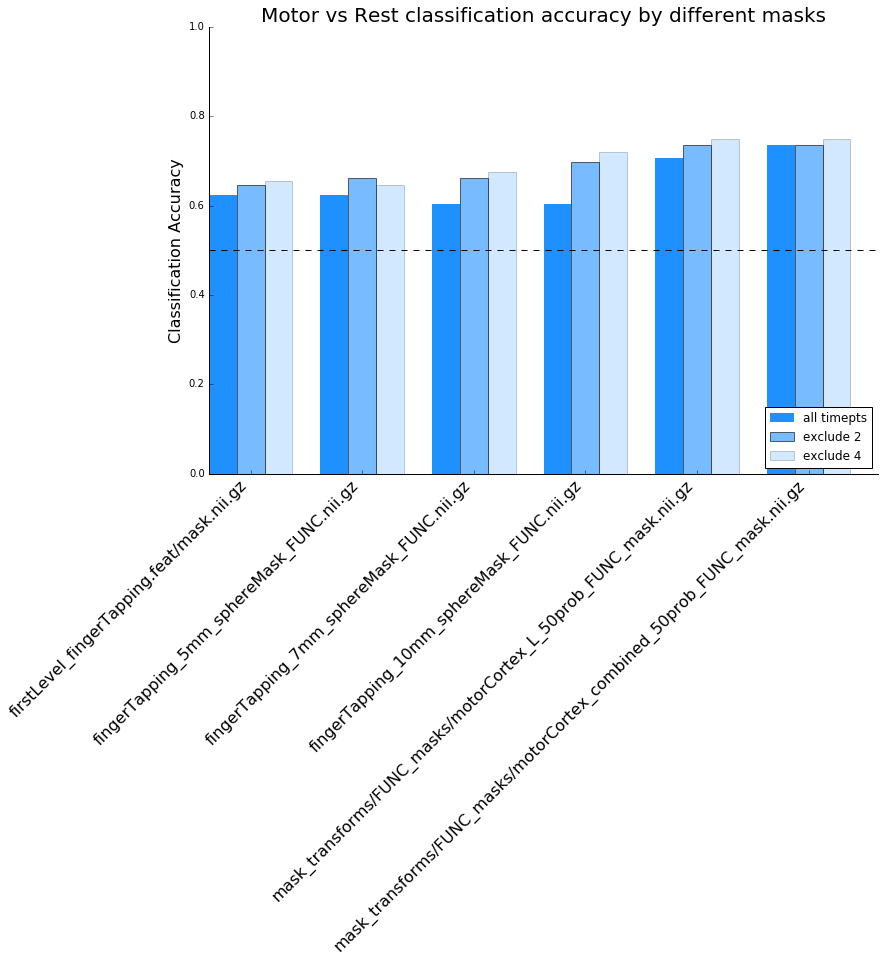

In [27]:
xInd = np.arange(6)
width = 0.25

fig,ax = plt.subplots(figsize=(12,8))
error_config = {'ecolor': '0.3', 'lw':3}

# all timepoints plot
allTmpts = ft_testAcc.loc[ft_testAcc['labels'] == 'fullRunLabels']
rects1 = ax.bar(xInd, 
                allTmpts['meanAcc'], 
                width, 
                color='dodgerblue',
                edgecolor='none',
                label='all timepts')


# exclude 2s plot
exclude2 = ft_testAcc.loc[ft_testAcc['labels'] == 'fullRunLabels_excl2']
rects2 = ax.bar(xInd+width,
               exclude2['meanAcc'],
               width,
               color='dodgerblue',
               alpha=.6,
               edgecolor='none',
               label='exclude 2')

# exclude 2s plot
exclude2 = ft_testAcc.loc[ft_testAcc['labels'] == 'fullRunLabels_excl4']
rects2 = ax.bar(xInd+width*2,
               exclude2['meanAcc'],
               width,
               color='dodgerblue',
               alpha=.2,
               edgecolor='none',
               label='exclude 4')

ax.axhline(y=.5, color='k', ls='--')

# format plot
ax.set_ylabel('Classification Accuracy', fontsize=16)
ax.set_ylim([0,1])
ax.set_title('Motor vs Rest classification accuracy by different masks', fontsize=20)
ax.set_xticks(xInd+width*1.5)
ax.set_xticklabels(masks, rotation=45, fontsize=16, ha='right')
ax.legend(loc=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(top='off', right='off')

### Labels: All

The classifier was built using ALL timepts from the training run

TRAIN: mean crossval acc: 0.6233846153846154, stdDev: 0.15533251220884967
TRAIN: mean crossval acc: 0.6793846153846155, stdDev: 0.046751008595898
TRAIN: mean crossval acc: 0.648, stdDev: 0.02966319816614161
TRAIN: mean crossval acc: 0.6015384615384616, stdDev: 0.07023207514162047
TRAIN: mean crossval acc: 0.6864615384615385, stdDev: 0.09649674244126144
TRAIN: mean crossval acc: 0.6944615384615385, stdDev: 0.10787939792676553


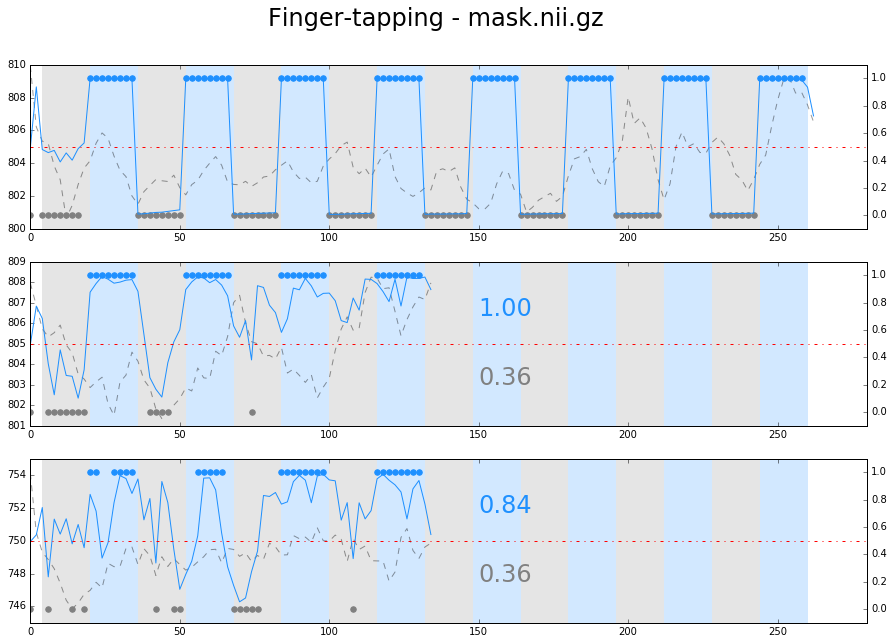

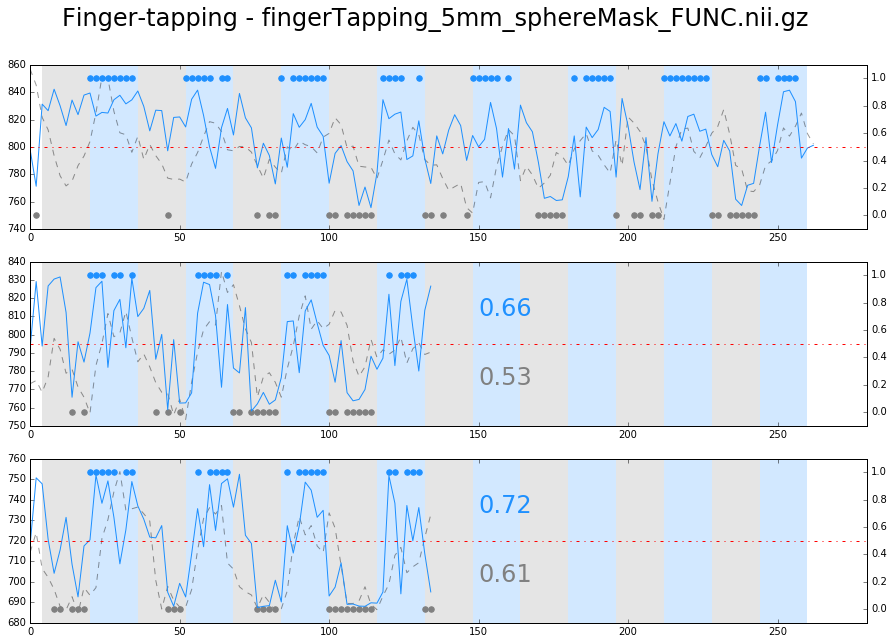

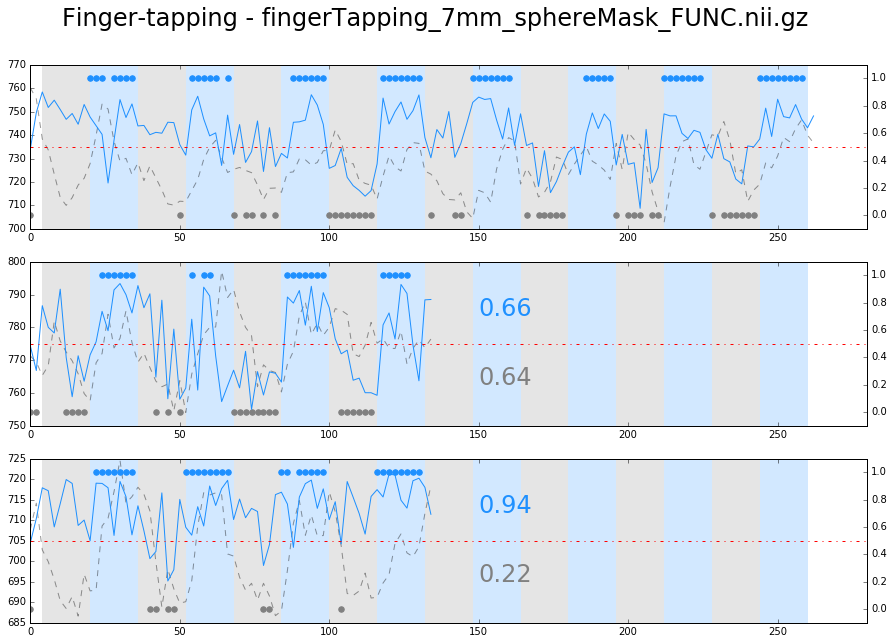

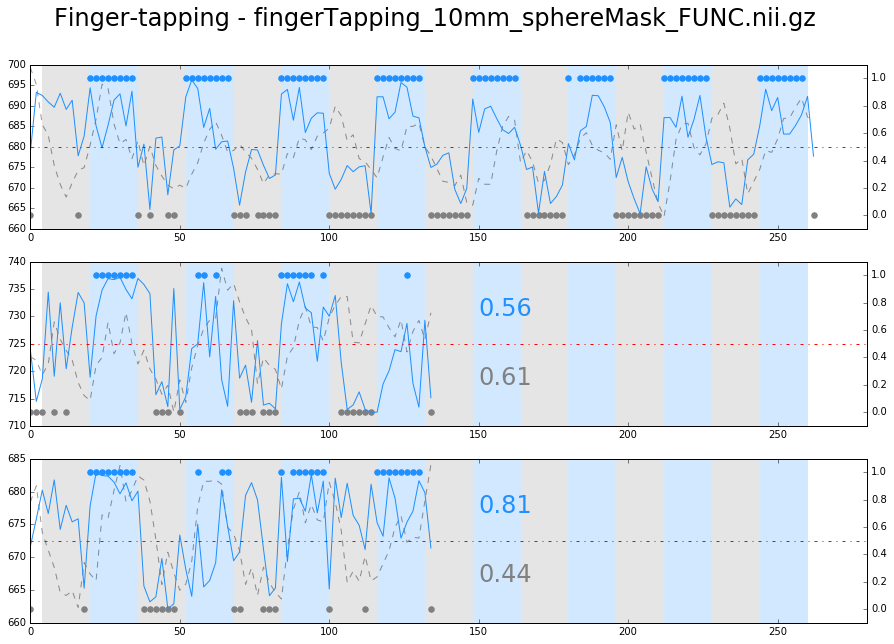

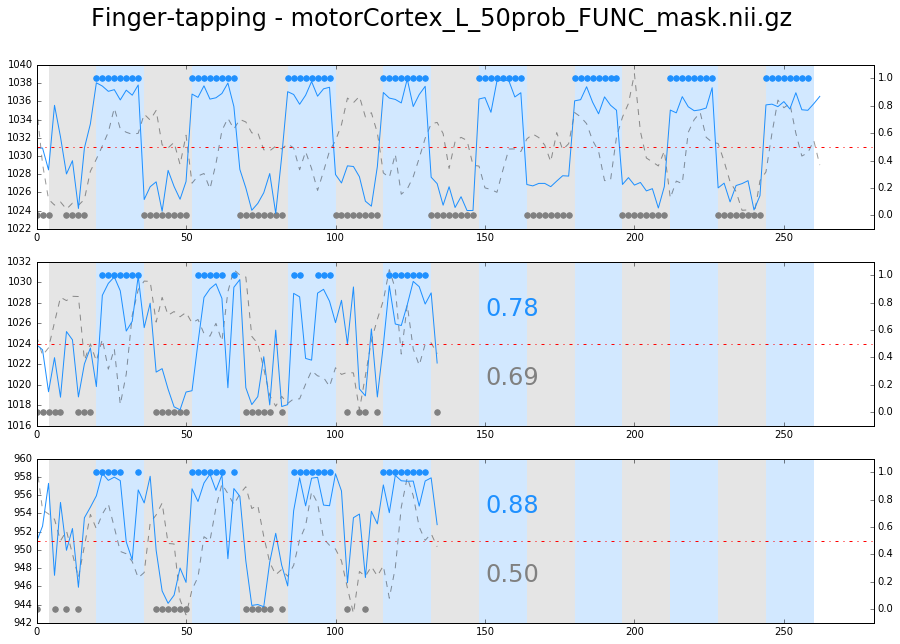

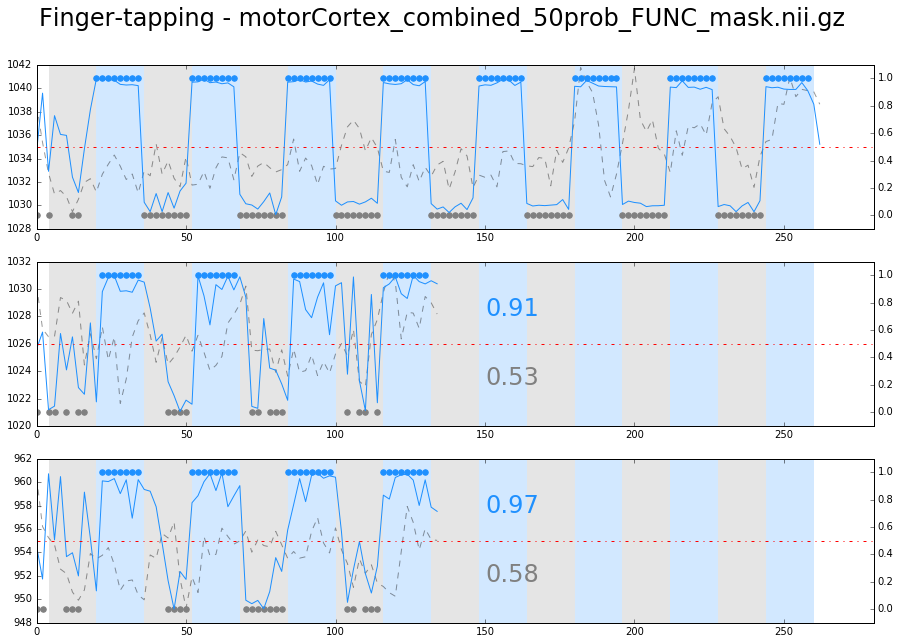

In [28]:
trainRun = join(rtDir, 'func_0000.nii.gz')
testRun1 = join(rtDir, 'func_0001.nii.gz')
testRun2 = join(rtDir, 'func_0002.nii.gz')
labelsFile = join(rtDir, 'timingFiles/fullRunLabels.txt')

masks = ['firstLevel_fingerTapping.feat/mask.nii.gz',
         'fingerTapping_5mm_sphereMask_FUNC.nii.gz', 
         'fingerTapping_7mm_sphereMask_FUNC.nii.gz', 
         'fingerTapping_10mm_sphereMask_FUNC.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_L_50prob_FUNC_mask.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_combined_50prob_FUNC_mask.nii.gz']

for mask in masks:
    maskFile = join(rtDir, mask)
    plotClassifierResults(maskFile, labelsFile, trainRun, testRun1, testRun2, 'finger-tapping')

### Labels: exclude 2

**one** timept on either side of each trial transition was excluded while building the classifier. Each trial thus contained 6 timepts

TRAIN: mean crossval acc: 0.6473684210526315, stdDev: 0.19093007523386374
TRAIN: mean crossval acc: 0.7389473684210527, stdDev: 0.06834813928735971
TRAIN: mean crossval acc: 0.8010526315789473, stdDev: 0.12712024538484654
TRAIN: mean crossval acc: 0.6542105263157895, stdDev: 0.1669309077967269
TRAIN: mean crossval acc: 0.7694736842105263, stdDev: 0.17564759480939918
TRAIN: mean crossval acc: 0.8021052631578949, stdDev: 0.14269274276067825


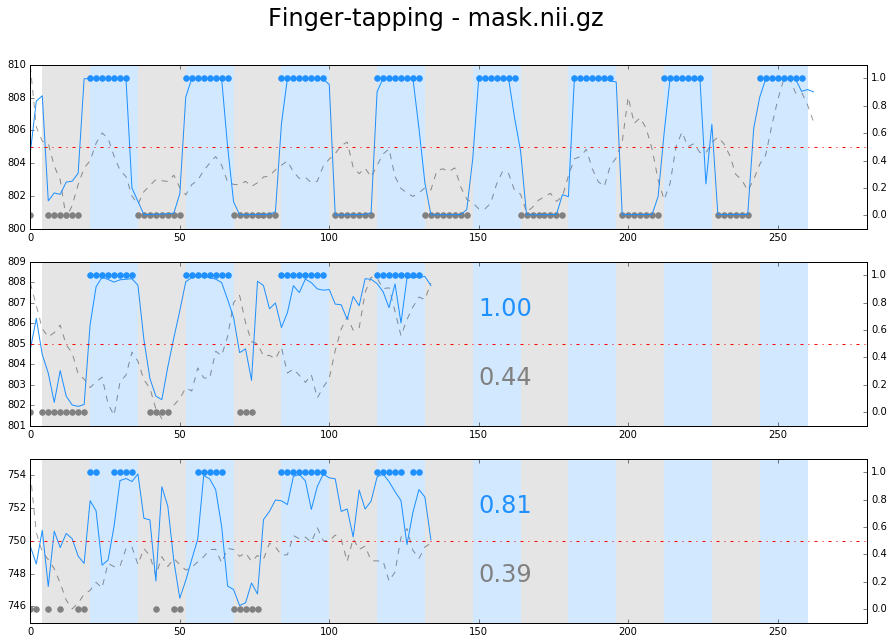

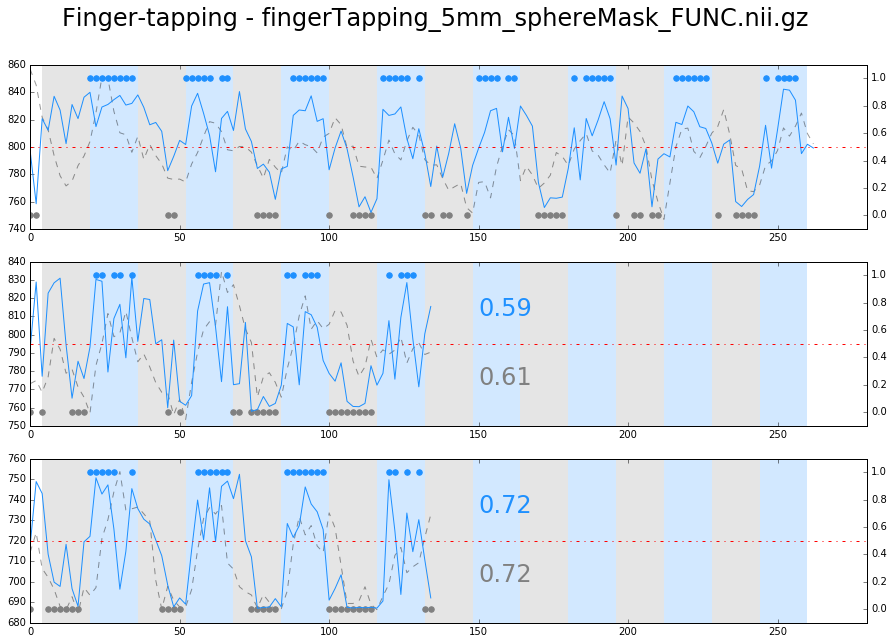

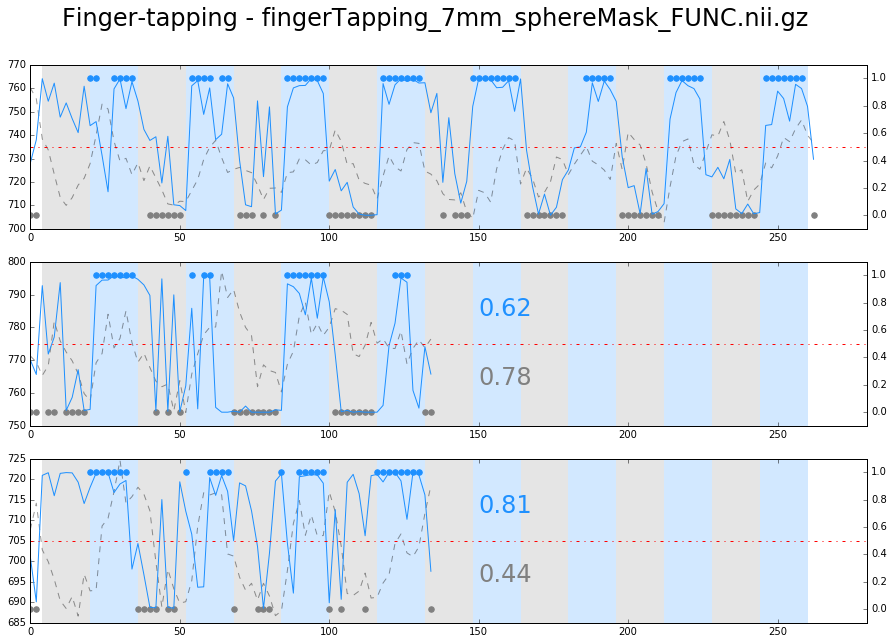

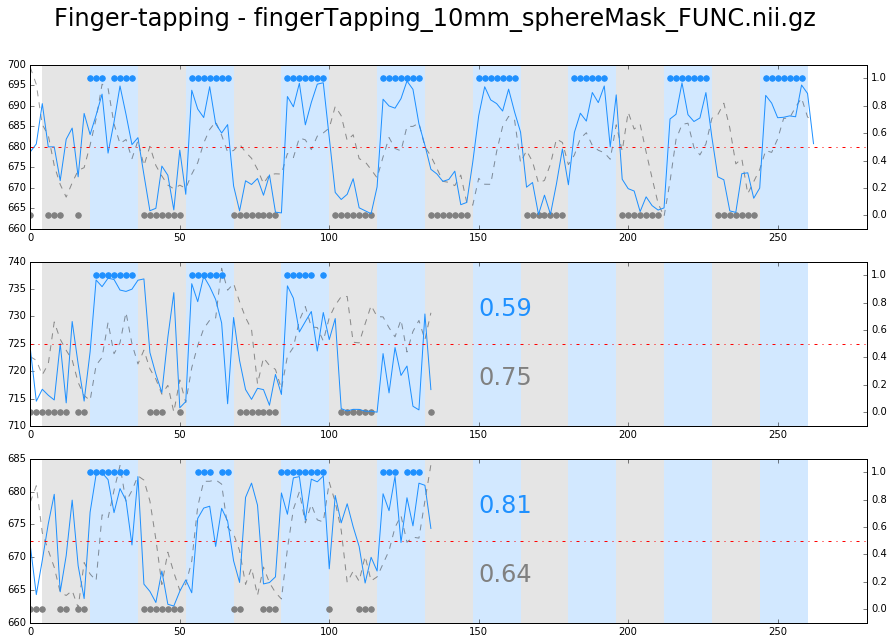

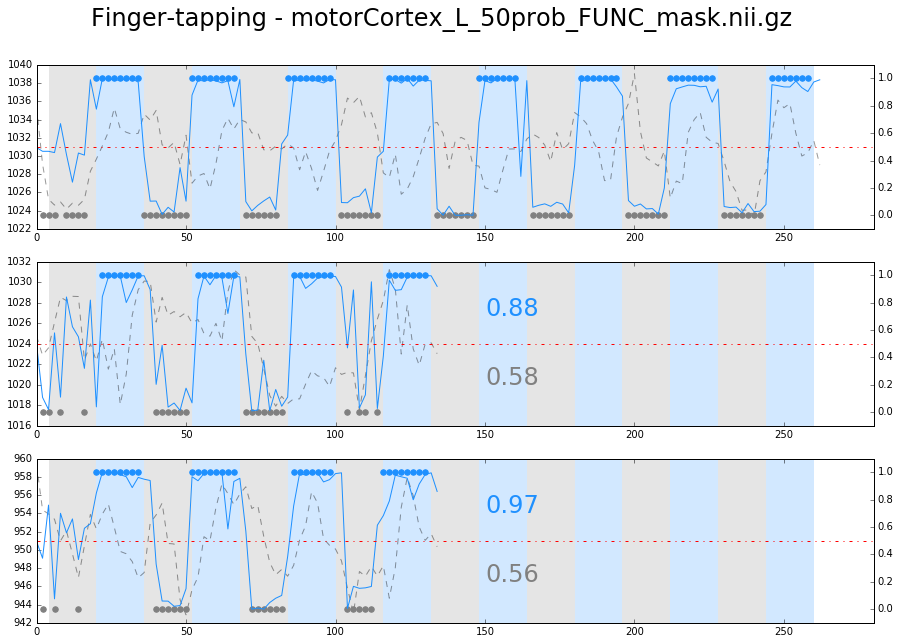

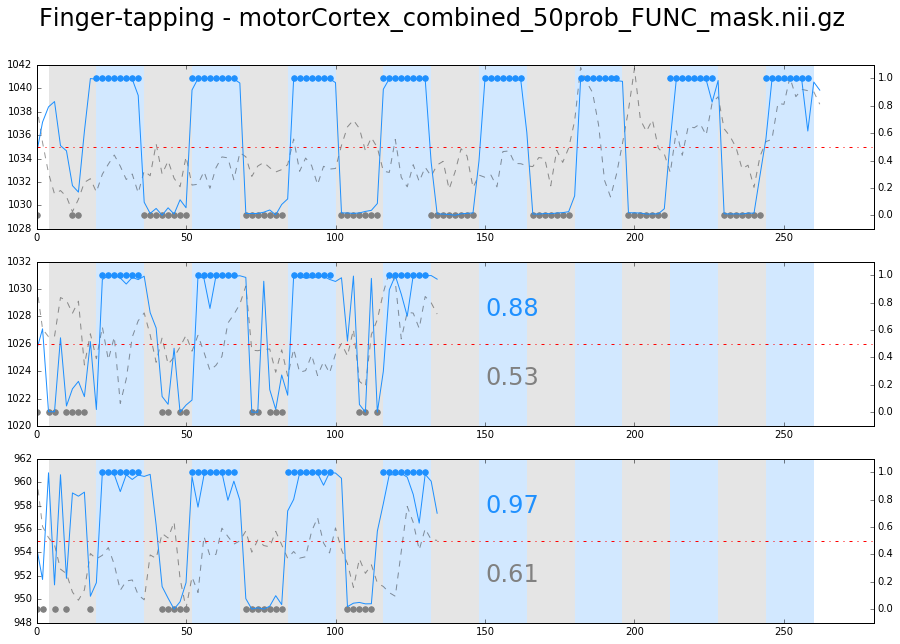

In [29]:
trainRun = join(rtDir, 'func_0000.nii.gz')
testRun1 = join(rtDir, 'func_0001.nii.gz')
testRun2 = join(rtDir, 'func_0002.nii.gz')
labelsFile = join(rtDir, 'timingFiles/fullRunLabels_excl2.txt')

masks = ['firstLevel_fingerTapping.feat/mask.nii.gz',
         'fingerTapping_5mm_sphereMask_FUNC.nii.gz', 
         'fingerTapping_7mm_sphereMask_FUNC.nii.gz', 
         'fingerTapping_10mm_sphereMask_FUNC.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_L_50prob_FUNC_mask.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_combined_50prob_FUNC_mask.nii.gz']

for mask in masks:
    maskFile = join(rtDir, mask)
    plotClassifierResults(maskFile, labelsFile, trainRun, testRun1, testRun2, 'finger-tapping')

### Labels: exclude 4 

**two** timepts on either side of each trial transition were excluded when building the classifier. Each trial thus contained 4 timepts

TRAIN: mean crossval acc: 0.5884615384615385, stdDev: 0.20911195721643366
TRAIN: mean crossval acc: 0.7205128205128205, stdDev: 0.11247031897159647
TRAIN: mean crossval acc: 0.7346153846153847, stdDev: 0.07730673554708377
TRAIN: mean crossval acc: 0.7782051282051282, stdDev: 0.14088571146478104
TRAIN: mean crossval acc: 0.7910256410256411, stdDev: 0.19643435615686977
TRAIN: mean crossval acc: 0.8551282051282051, stdDev: 0.14434326097474431


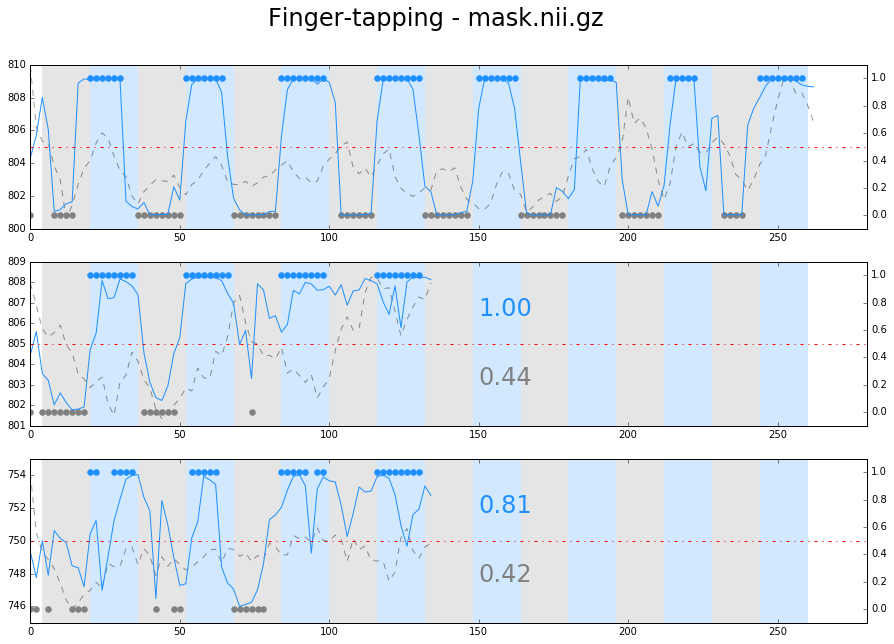

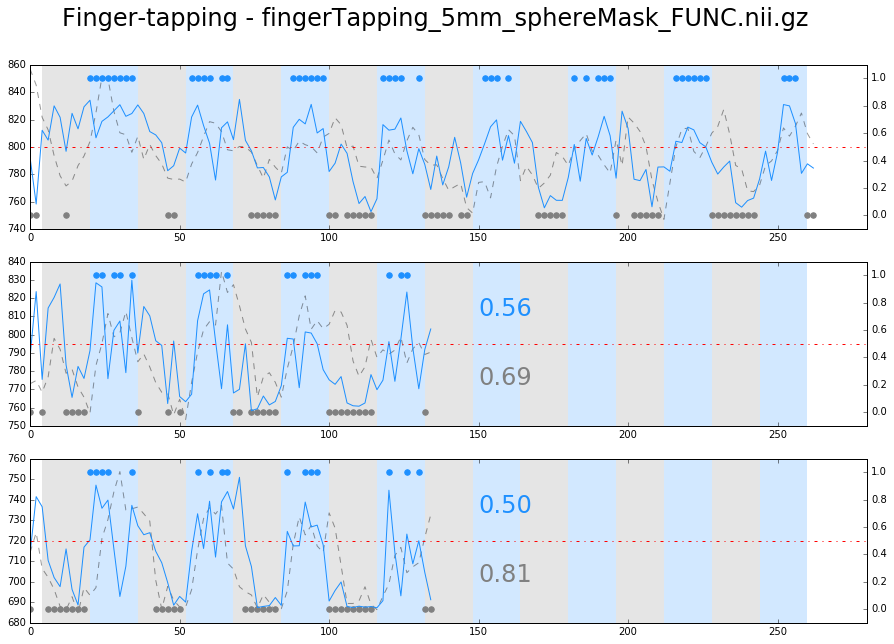

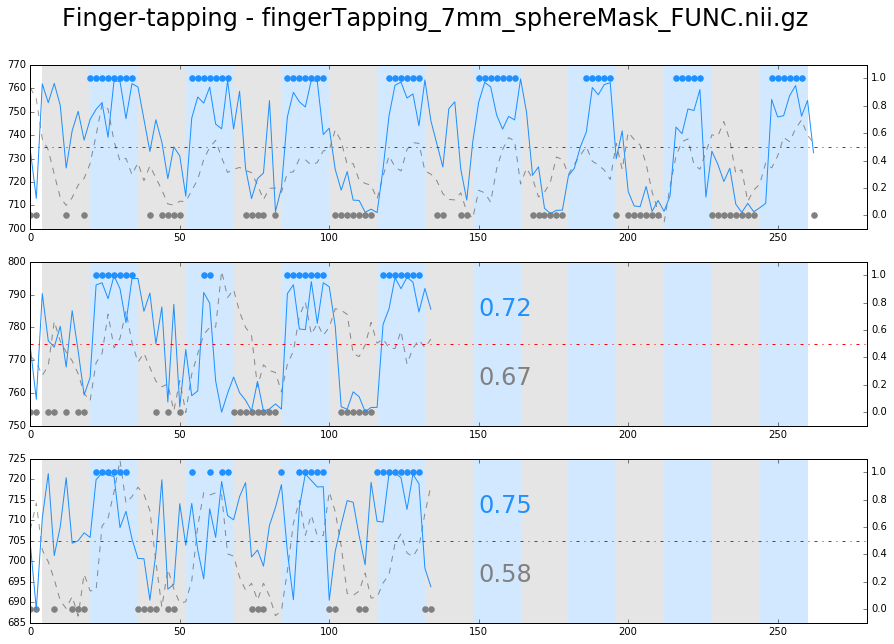

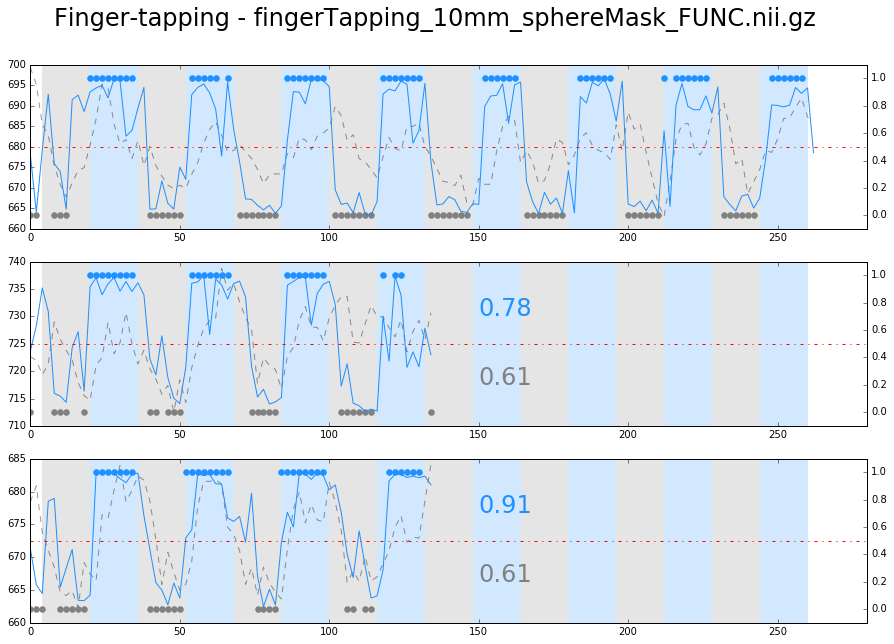

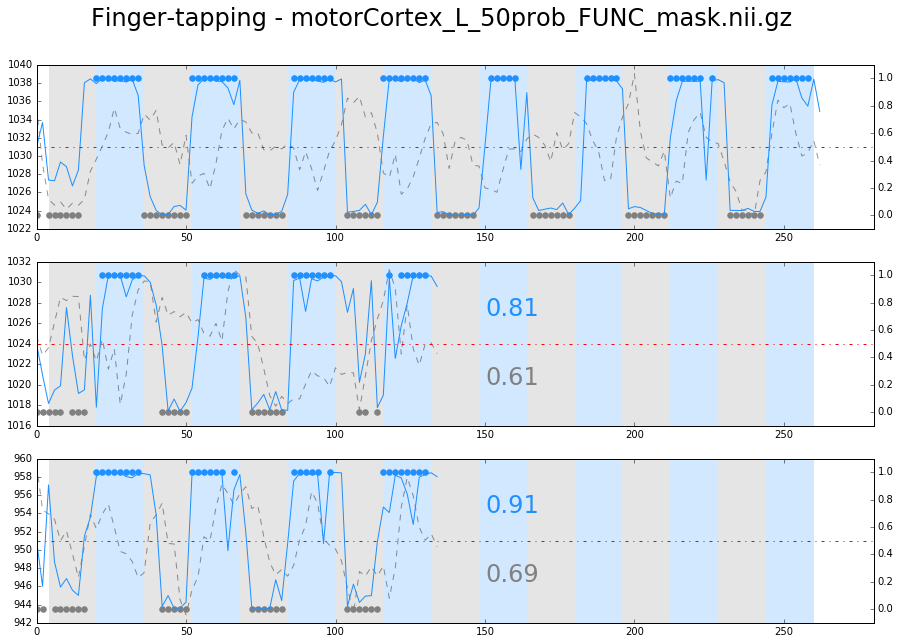

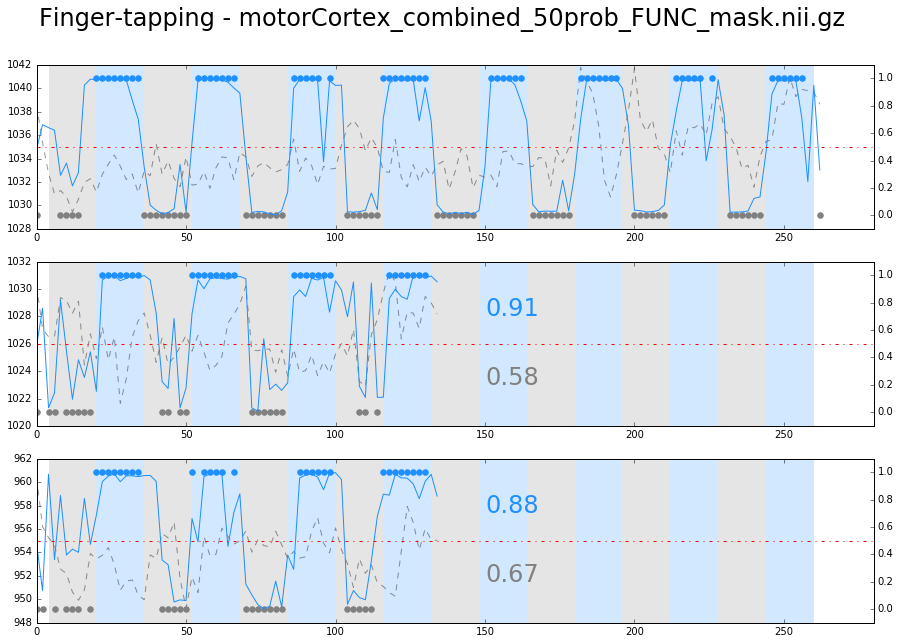

In [30]:
trainRun = join(rtDir, 'func_0000.nii.gz')
testRun1 = join(rtDir, 'func_0001.nii.gz')
testRun2 = join(rtDir, 'func_0002.nii.gz')
labelsFile = join(rtDir, 'timingFiles/fullRunLabels_excl4.txt')

masks = ['firstLevel_fingerTapping.feat/mask.nii.gz',
         'fingerTapping_5mm_sphereMask_FUNC.nii.gz', 
         'fingerTapping_7mm_sphereMask_FUNC.nii.gz', 
         'fingerTapping_10mm_sphereMask_FUNC.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_L_50prob_FUNC_mask.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_combined_50prob_FUNC_mask.nii.gz']

for mask in masks:
    maskFile = join(rtDir, mask)
    plotClassifierResults(maskFile, labelsFile, trainRun, testRun1, testRun2, 'finger-tapping')

# Imagery Analysis

In [33]:
imagery_testAcc = pd.DataFrame(columns=['mask', 'labels', 'meanAcc'])

masks = ['firstLevel_imagery.feat/mask.nii.gz',
         'imagery_5mm_sphereMask_FUNC.nii.gz', 
         'imagery_7mm_sphereMask_FUNC.nii.gz', 
         'imagery_10mm_sphereMask_FUNC.nii.gz',
         'imagery_zstatThr2-3_Mask_FUNC.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_L_50prob_FUNC_mask.nii.gz',
         'mask_transforms/FUNC_masks/motorCortex_combined_50prob_FUNC_mask.nii.gz']

labels = ['timingFiles/fullRunLabels.txt',
         'timingFiles/fullRunLabels_excl2.txt',
         'timingFiles/fullRunLabels_excl4.txt']

trainFunc = join(rtDir, 'func_0003.nii.gz')
testFunc1 = join(rtDir, 'func_0004.nii.gz')
testFunc2 = join(rtDir, 'func_0005.nii.gz')

for mask in masks:
    for label in labels: 
        
        # set inputs
        maskFile = join(rtDir, mask)
        labelFile = join(rtDir, label)
        
        # build classifier
        clf = buildClassifier(trainFunc, maskFile, labelFile)
        
        # timepts label array for test runs
        timeptLabels = np.array(['Rest', 'Rest'] + list(np.repeat(['Rest', 'Active'], 8))*4 + ['Rest', 'Rest'])
        
        # test 1 accuracy
        pc, pp = applyClassifier(testFunc1, maskFile, clf)
        test1_acc = sum(timeptLabels == pc)/len(timeptLabels)
        
        # test 2 accuracy
        pc, pp = applyClassifier(testFunc2, maskFile, clf)
        test2_acc = sum(timeptLabels == pc)/len(timeptLabels)
        
        # calculate mean accuracy across both test runs
        meanAcc = np.mean([test1_acc, test2_acc])
        
        # format results and add to master dataframe
        label_abbrev = label.split('/')[1].split('.')[0]
        imagery_testAcc = imagery_testAcc.append({'mask': mask,
                                       'labels': label_abbrev,
                                       'meanAcc': meanAcc}, ignore_index=True)

imagery_testAcc

TRAIN: mean crossval acc: 0.7123076923076923, stdDev: 0.12401183375485826
TRAIN: mean crossval acc: 0.7826315789473683, stdDev: 0.1679895788879728
TRAIN: mean crossval acc: 0.7692307692307693, stdDev: 0.2527950265408459
TRAIN: mean crossval acc: 0.5553846153846154, stdDev: 0.071235919401786
TRAIN: mean crossval acc: 0.5642105263157895, stdDev: 0.11808255715688552
TRAIN: mean crossval acc: 0.5448717948717948, stdDev: 0.18989945088497973
TRAIN: mean crossval acc: 0.5710769230769231, stdDev: 0.10593913626094927
TRAIN: mean crossval acc: 0.6263157894736843, stdDev: 0.16341236522378974
TRAIN: mean crossval acc: 0.5166666666666667, stdDev: 0.18183446822042462
TRAIN: mean crossval acc: 0.4621538461538462, stdDev: 0.1323313037965584
TRAIN: mean crossval acc: 0.6368421052631579, stdDev: 0.14736842105263157
TRAIN: mean crossval acc: 0.5948717948717948, stdDev: 0.21231016968702
TRAIN: mean crossval acc: 0.7196923076923076, stdDev: 0.11111228927711986
TRAIN: mean crossval acc: 0.7910526315789473, 

,mask,labels,meanAcc
0,firstLevel_imagery.feat/mask.nii.gz,fullRunLabels,0.735294
1,firstLevel_imagery.feat/mask.nii.gz,fullRunLabels_excl2,0.713235
2,firstLevel_imagery.feat/mask.nii.gz,fullRunLabels_excl4,0.713235
3,imagery_5mm_sphereMask_FUNC.nii.gz,fullRunLabels,0.691176
4,imagery_5mm_sphereMask_FUNC.nii.gz,fullRunLabels_excl2,0.639706
5,imagery_5mm_sphereMask_FUNC.nii.gz,fullRunLabels_excl4,0.654412
6,imagery_7mm_sphereMask_FUNC.nii.gz,fullRunLabels,0.727941
7,imagery_7mm_sphereMask_FUNC.nii.gz,fullRunLabels_excl2,0.654412
8,imagery_7mm_sphereMask_FUNC.nii.gz,fullRunLabels_excl4,0.669118
9,imagery_10mm_sphereMask_FUNC.nii.gz,fullRunLabels,0.566176


## Plot results
### Overall

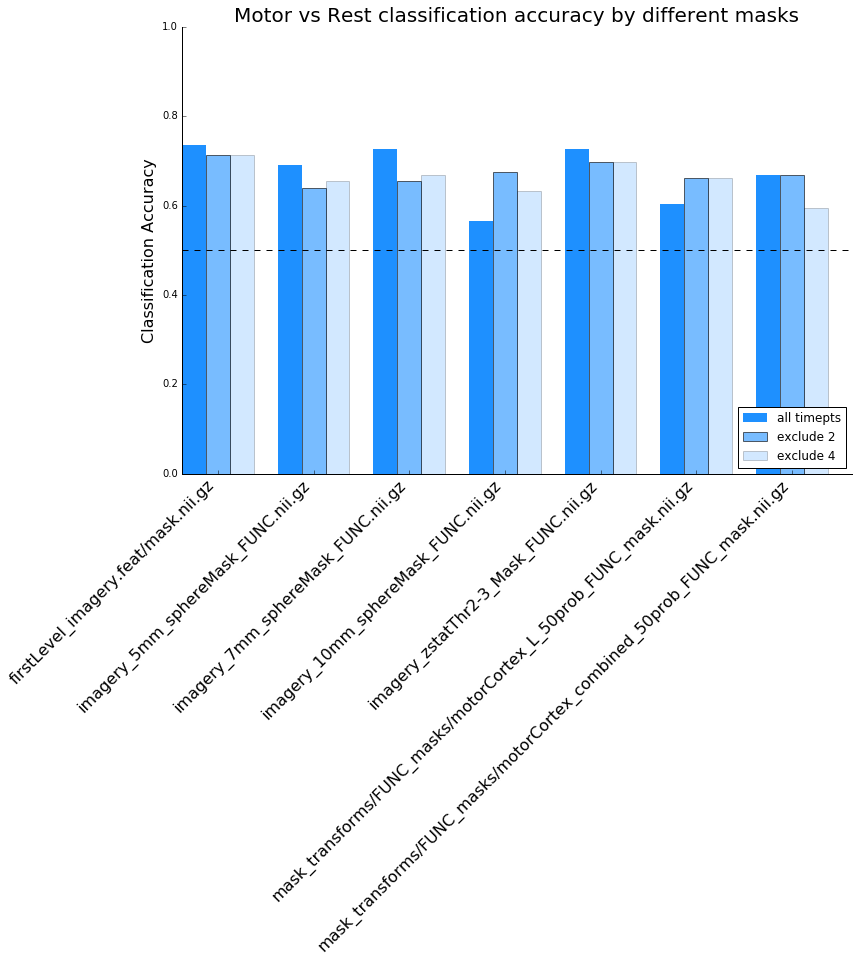

In [34]:
xInd = np.arange(7)
width = 0.25

fig,ax = plt.subplots(figsize=(12,8))
error_config = {'ecolor': '0.3', 'lw':3}

# all timepoints plot
allTmpts = imagery_testAcc.loc[imagery_testAcc['labels'] == 'fullRunLabels']
rects1 = ax.bar(xInd, 
                allTmpts['meanAcc'], 
                width, 
                color='dodgerblue',
                edgecolor='none',
                label='all timepts')


# exclude 2s plot
exclude2 = imagery_testAcc.loc[imagery_testAcc['labels'] == 'fullRunLabels_excl2']
rects2 = ax.bar(xInd+width,
               exclude2['meanAcc'],
               width,
               color='dodgerblue',
               alpha=.6,
               edgecolor='none',
               label='exclude 2')

# exclude 2s plot
exclude2 = imagery_testAcc.loc[imagery_testAcc['labels'] == 'fullRunLabels_excl4']
rects2 = ax.bar(xInd+width*2,
               exclude2['meanAcc'],
               width,
               color='dodgerblue',
               alpha=.2,
               edgecolor='none',
               label='exclude 4')

ax.axhline(y=.5, color='k', ls='--')

# format plot
ax.set_ylabel('Classification Accuracy', fontsize=16)
ax.set_ylim([0,1])
ax.set_title('Motor vs Rest classification accuracy by different masks', fontsize=20)
ax.set_xticks(xInd+width*1.5)
ax.set_xticklabels(masks, rotation=45, fontsize=16, ha='right')
ax.legend(loc=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(top='off', right='off')

## TRY WITH DIFFERENT ANAT MASKS